# **Malaria FastAI Detector** 
![Malaria Data Input](https://drive.google.com/uc?export=view&id=1Ca5J-DhQSHc_XsPBDViORgL4c8gZAppi)

Malaria is a mosquito-borne infectious disease that affects humans, which can cause coma or death in several cases if it is not properly treated. Approximately 93% of the cases and 94% of deaths occurred in Africa, where the healthcare system is very deficient due to the lack of resources.

There are several methods and tests which can be used for malaria detection. Microscopic examination of blood is the best known method for diagnosis, but it is a very slow method because a trained technician has to manually examine around 5000 cells and count how many cells has a parasite inside them. Therefore, this is the point where AI can make the difference by building an automatic malaria classification system.

Today, I bring a FastAI implementation of a Malaria detector, with the goal of reproducing state-of-art results (97% precision), using FastAi library instead of Keras, which was the one proposed in the original paper.

The results of my training were a precision of 98% over the test set of images using a ResNet-50 model, and a 97% precision with a ResNet-18, which offers best tradeoff for using it in mobile devices.

**Google's colab author:** 
[Daniel Verdu Torres](https://davertor.github.io/)

**Referencias:**
* [Malaria Wiki](https://en.wikipedia.org/wiki/Malaria )
* [Malaria webapp detector](https://lhncbc.nlm.nih.gov/system/files/pub9752.pdf )


### **IMPORTANT**
First of all, remember to check that GPU option is selected in Runtime environment --> Change runtime environment

## Check GPU specs

Check the hardware resources provided by Google Colab

In [ ]:
#GPU count and name
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla K80 (UUID: GPU-516c5224-d34d-50db-3c0e-4781f535cf9e)
Wed Aug 26 15:09:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                      

## Synchronize with Drive

Connect your colab to your Google Drive account

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Configuring required libraries

In [ ]:
# Check if fastai and pytorch are installed
!pip list | grep -e fastai -e torch -e torchvision

# If not, uncomment this line and run to install them
#!pip install torch torchvision fastai

fastai                   1.0.61         
torch                    1.6.0+cu101    
torchsummary             1.5.1          
torchtext                0.3.1          
torchvision              0.7.0+cu101    


In [ ]:
import fastai
print(fastai.__version__)
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate
from fastai.callbacks import SaveModelCallback

import numpy as np
from pathlib import Path

1.0.61


In [ ]:
# Hide iPython warnings
import warnings
warnings.filterwarnings('ignore')

## Dowload Malaria Dataset

In [ ]:
classes = ['Uninfected', 'Parasitized']

root_dir = "/content/gdrive/My Drive/DL_Datasets/"
base_dir = root_dir + 'Malaria/'

path = Path(base_dir)
path

PosixPath('/content/gdrive/My Drive/DL_Datasets/Malaria')

## Loading data to an ImageDataBunch

In [ ]:
### Legend
#  ds_tfms: To define Data augmentation. It can be equal to a function called
            # get_transforms(do_flip=True, flip_vert=True), in which you can 
            # include data augm. transf.
# valid_pct: controls the percentage of images that will be randomly chosen to
            # be in the validation set
# normalize: Normalize the data in our object

bs = 32
size = 64 # Test with 128 and 64

tfms = get_transforms(max_rotate=None, max_warp=None, max_zoom=1.0)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=bs, 
                                  ds_tfms=tfms, num_workers=4, size=size).normalize(imagenet_stats)

print('Classes of the dataset: ', data.classes)
print('Train size:', len(data.train_ds))
print('Valid size:', len(data.valid_ds))

data

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

Classes of the dataset:  ['Parasitized', 'Uninfected']
Train size: 1600
Valid size: 400


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: /content/gdrive/My Drive/DL_Datasets/Malaria;

Valid: LabelList (400 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Parasitized,Uninfected,Parasitized,Parasitized,Parasitized
Path: /content/gdrive/My Drive/DL_Datasets/Malaria;

Test: None

### Inspect the dataset

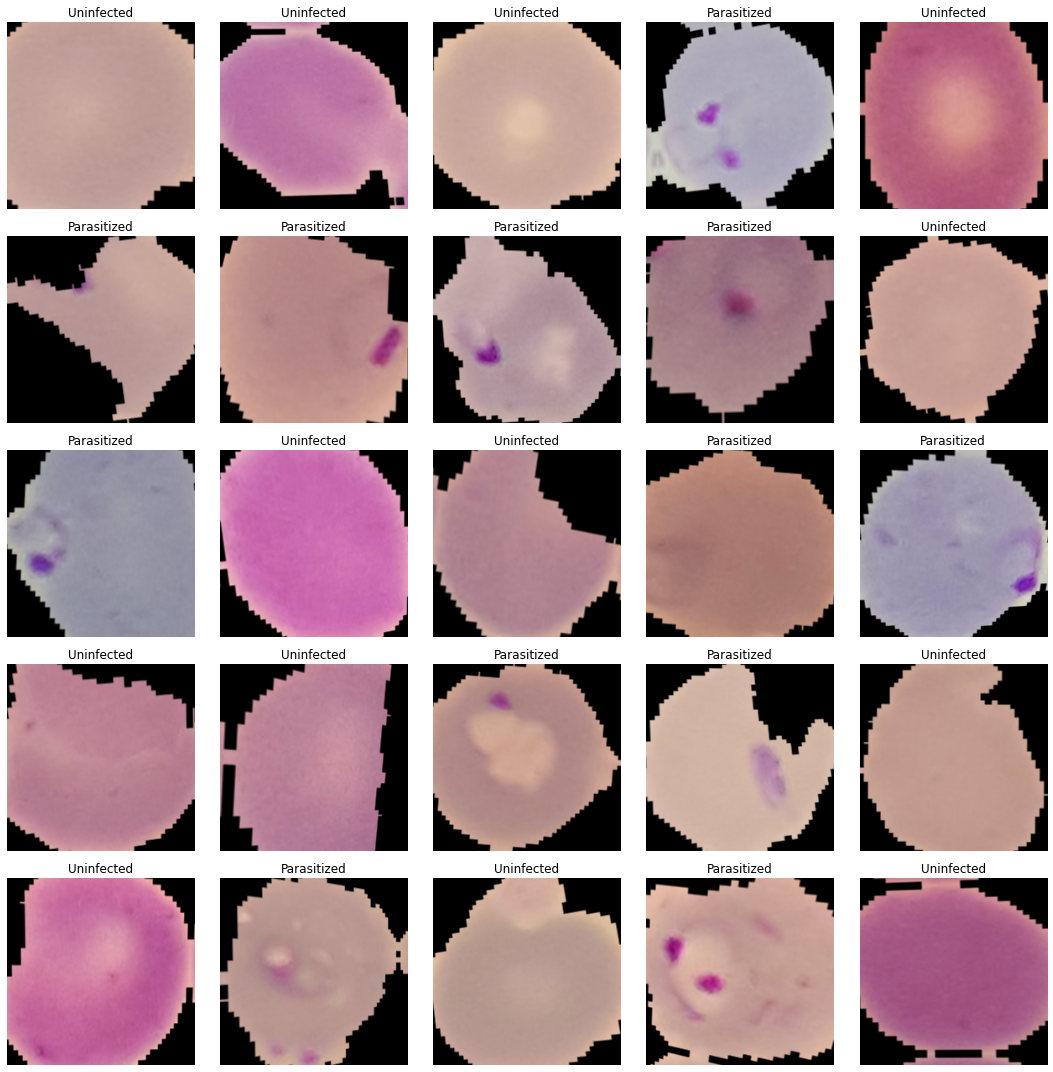

In [ ]:
data.show_batch(rows=5, figsize=(15,15))

## Define own callback

In [ ]:
# # Create our own callback for calculating F1-score

# class fbeta_binary_me(Callback):
#     "Computes the f_beta between preds and targets for binary text classification"

#     def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
#         self.beta2=beta2**2
#         self.eps = eps
#         self.sigmoid = sigmoid
    
#     def on_epoch_begin(self, **kwargs):
#         self.TP = 0
#         self.total_y_pred = 0   
#         self.total_y_true = 0
    
#     def on_batch_end(self, last_output, last_target, **kwargs):
#         y_pred = last_output
#         y_pred = y_pred.softmax(dim = 1)        
#         y_pred = y_pred.argmax(dim=1)
#         y_true = last_target.float()
        
#         self.TP += ((y_pred==1) * (y_true==1)).float().sum()
#         self.total_y_pred += (y_pred==1).float().sum()
#         self.total_y_true += (y_true==1).float().sum()
    
#     def on_epoch_end(self, **kwargs):
#         prec = self.TP/(self.total_y_pred+self.eps)
#         rec = self.TP/(self.total_y_true+self.eps)
#         res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
#         #self.metric = res.mean()
#         self.metric = res

In [ ]:
# fbeta_binary_me = fbeta_binary_me(1)

## Ejecutar el entrenamiento

In [ ]:
# You can include a callback function called ShowGraph to return a graph for 
# whatever it does
learner = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate],
                     model_dir=path/'models/')

# learner = create_cnn(data, models.resnet50, metrics=accuracy, callback_fns=ShowGraph)
# learner = create_cnn(data, models.resnet50, metrics=[accuracy, FBeta(beta=1)])
# learner = create_cnn(data, models.resnet50, metrics=[accuracy, fbeta_binary_me])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


## Finds optimal learning rate

We want to choose a learning rate, for which the loss is still decreasing
with the steepest slope.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


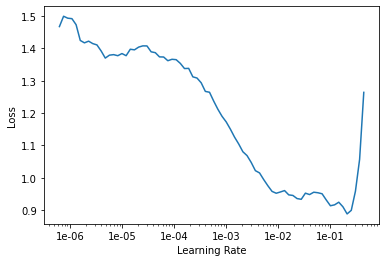

In [ ]:
learner.lr_find()
learner.recorder.plot()


By default, only the fully connected layers at the top are unfrozen (can be trained).

To train the layers we can use the fit or fit_one_cycle method. The fit method is the “normal” way of training a neural net with a constant learning rate, whilst the fit_one_cycle method uses something called the 1 cycle policy, which basically changes the learning rate over time to achieve better results.

## Train the model

In [ ]:
# Train only fully connected layers
learner.fit_one_cycle(5, slice(5e-3, 5e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.778760,0.374332,0.875000,0.125000,00:07
1,0.458110,0.266343,0.907500,0.092500,00:07
2,0.314659,0.219939,0.927500,0.072500,00:07
3,0.241502,0.218216,0.937500,0.062500,00:07
4,0.182122,0.221383,0.935000,0.065000,00:07


## Plot training curves

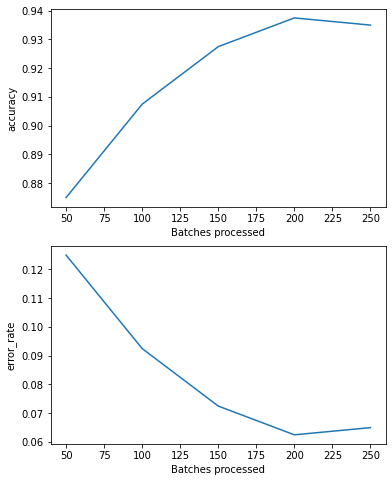

In [ ]:
learner.recorder.plot_metrics()

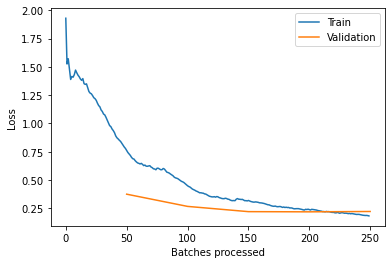

In [ ]:
learner.recorder.plot_losses()

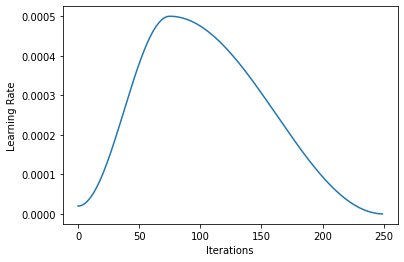

In [ ]:
learner.recorder.plot_lr()

## Evaluate results

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

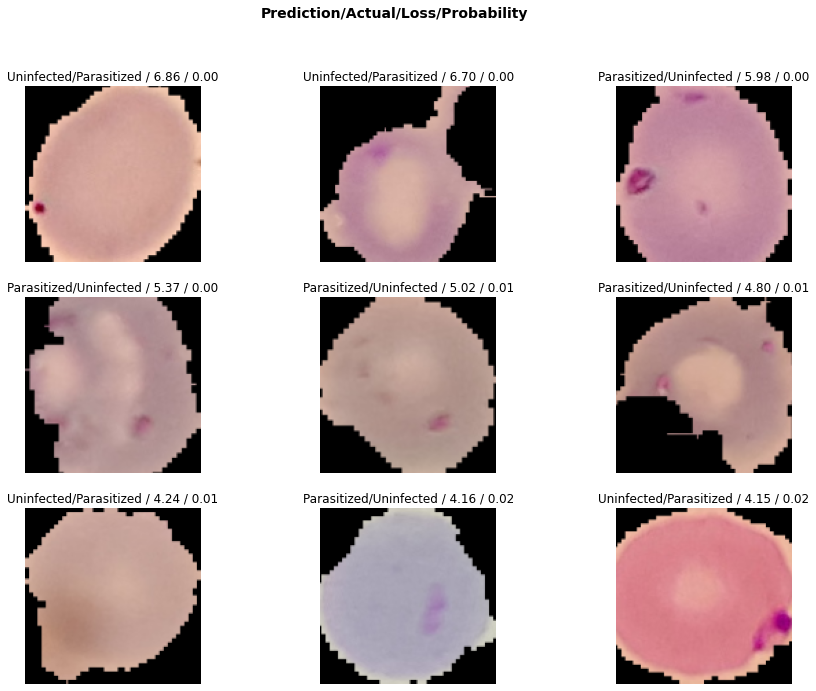

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
# interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

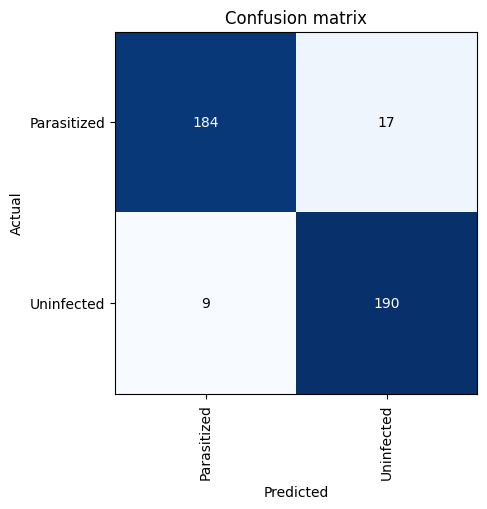

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

## Checkpoint the model

In [ ]:
# We will save the model as a checkpoint
model_checkpoint = 'Malaria-resnet34-11_08_20-size_128-stage-1'

In [ ]:
learner.save(model_checkpoint)

## Fine-tune the model

Now, we will unfreeze more layers. 

With lr_find we are searching for the point with the steepest downward slope that still has a high value

To now train the model using differential learning rates we need to pass the max_lr argument to the fit_one_cycle method.

In [ ]:
learner.load(model_checkpoint)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


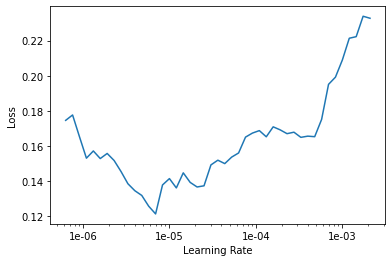

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(10, max_lr=slice(2e-6,7e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.172772,0.216106,0.935000,0.065000,00:07
1,0.191340,0.210489,0.937500,0.062500,00:07
2,0.180575,0.209999,0.940000,0.060000,00:07
3,0.185780,0.210584,0.937500,0.062500,00:07
4,0.159394,0.201047,0.940000,0.060000,00:07
5,0.148642,0.190040,0.940000,0.060000,00:07
6,0.130666,0.190921,0.942500,0.057500,00:07
7,0.134015,0.183865,0.942500,0.057500,00:07
8,0.120130,0.187449,0.942500,0.057500,00:07
9,0.110901,0.193058,0.940000,0.060000,00:07


### Alternative: Load a model to evaluate it

In [ ]:
model_name = 'Malaria-resnet34-11_08_20-stage-1'
learner.load(model_name)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: /content/gdrive/My Drive/DL_Datasets/Malaria;

Valid: LabelList (400 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Parasitized,Uninfected,Parasitized,Parasitized,Parasitized
Path: /content/gdrive/My Drive/DL_Datasets/Malaria;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

## Show results

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

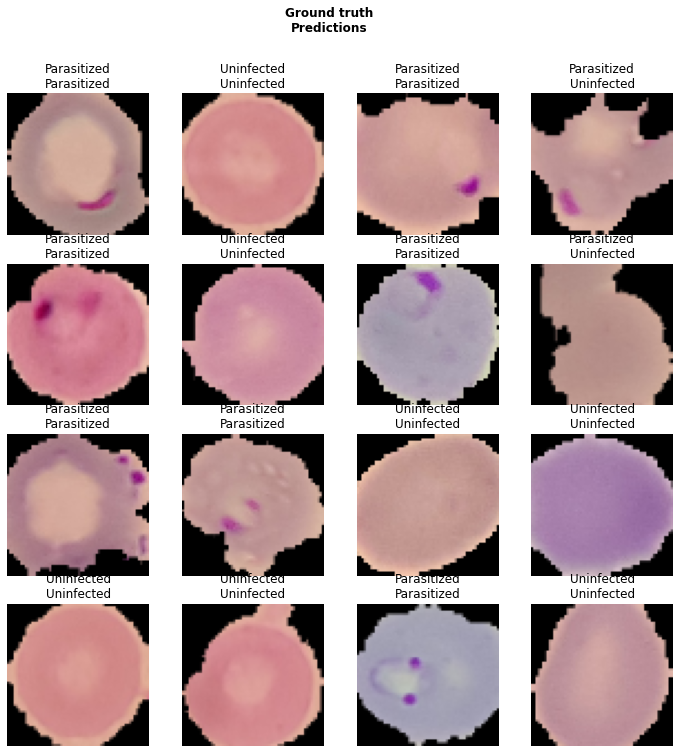

In [ ]:
learner.show_results(rows=4, figsize=(12,12))

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

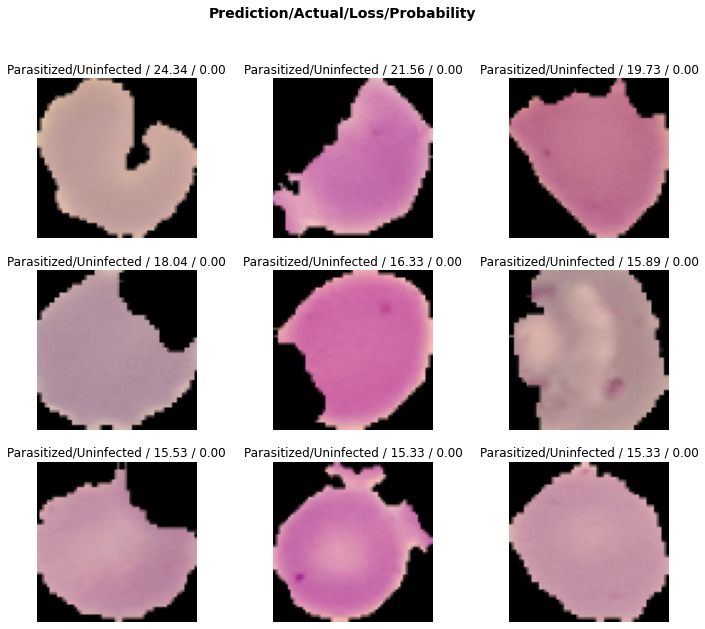

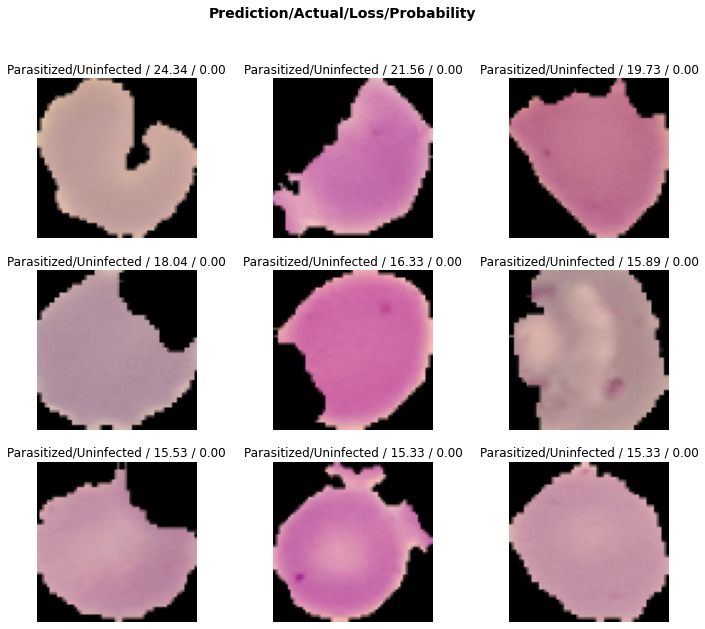

In [ ]:
interp.plot_top_losses(9, figsize=(12,10))

# Also, you can plot heatmap overlapped to the image
interp.plot_top_losses(9, figsize=(12,10), heatmap=True)

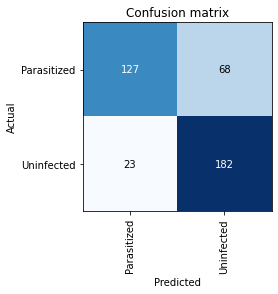

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 68), ('Uninfected', 'Parasitized', 23)]

In [ ]:
y = data.valid_ds.y.items
preds,y_hat,losses = learner.get_preds(with_loss=True)

from sklearn.metrics import classification_report

y_hat = np.argmax(preds,axis=1)
print(classification_report(y, y_hat, target_names=data.train_ds.y.classes))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

              precision    recall  f1-score   support

 Parasitized       0.72      0.89      0.80       195
  Uninfected       0.86      0.68      0.76       205

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.80      0.78      0.78       400



## Cleaning data if necessary

FastAI also provides functionality for cleaning your data using Jupyter widgets. The ImageCleaner class displays images for relabeling or deletion and saves changes in path as 'cleaned.csv'.

In [ ]:
# from fastai.widgets import *

# ds, idxs = DatasetFormatter().from_toplosses(learn)
# ImageCleaner(ds, idxs, path)

## Final training if necessary

In [ ]:
# df = pd.read_csv(path/'cleaned.csv', header='infer')
# print(df.head())

# db = (ImageItemList.from_df(df, path)
#                    .random_split_by_pct(0.2)
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch(bs=8)).normalize(imagenet_stats)

In [ ]:
# print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
# print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

In [ ]:
# # Show a random batch
# db.show_batch()

In [ ]:

# learner.load('Malaria-stage-1') # loading the weights
# learner.data = db # replacing the data

# learner.freeze()
# learner.fit_one_cycle(4)

# learner.unfreeze()

# learner.lr_find()
# learner.recorder.plot()

# learner.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))
# learner.save('Malaria-stage-2')

## Save the final model

In [ ]:
learner.save('Malaria-resnet34-11_08_20-size_224')